In [4]:
import numpy as np
import matplotlib.pyplot as plt
from beam_mechanics_3_script import simulate_beam, m_line_of_s
from constants import *

A reference trajectory is created in the form of a sine wave

In [5]:
def con_ref(theta_ref):
    return (theta_ref,0)


def sine_reference(Amp, freq, offset_rad = 0.0, phase_rad=0.0):
    w = 2*np.pi*freq
    return lambda t: (offset_rad + Amp*np.sin(w*t+phase_rad), Amp*w*np.cos(w*t+phase_rad))


Here we build the reference trajectory which the controller will follow

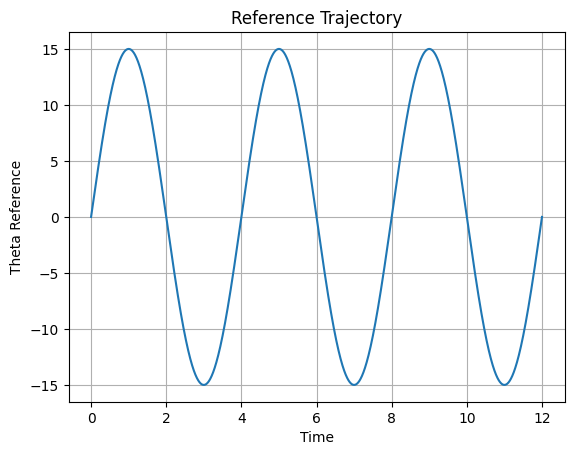

In [6]:
T = 12
dt = 0.005
amplitude = 15
frequency = 0.25
offset = 0.0
phase_shift = 0.0
time = np.arange(0,T+dt,dt)
theta_ref_mk = sine_reference(amplitude, frequency, offset, phase_shift)
theta_ref_values = []
for ti in time:
    theta_ref_values.append(theta_ref_mk(ti)[0])

theta_ref = np.array(theta_ref_values)
plt.figure()
plt.plot(time, theta_ref)
plt.xlabel("Time")
plt.ylabel("Theta Reference")
plt.title("Reference Trajectory")
plt.grid()
plt.show()
    



We will now implement a basic PD controller. We add a parameter to smooth the derivative also.

In [132]:
def pd_controller(p_vec, ref_traj, time, dt, gain, kp, kd):
    t_hist, u_hist, err_hist, delt_u_hist, theta_hist, ref_hist = [], [], [], [], [], []
    psi_up = 0.0
    e_int = 0.0
    prev_error = 0.0
    prev_theta = None         
    d_filt = 0.0
    alpha = dt / (0.2 + dt)

    N = int(time/dt)
    for k in range(N):
        t = k*dt
        if k%(N//10) == 0:
            print(f"Progress: {100*k//N}% done")
        if callable(ref_traj):
            theta_ref, _ = ref_traj(t)
        else:
            theta_ref, _ = ref_traj

        theta_real, _, _, _ = simulate_beam(
            p_vec, psi_up,
            L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
            MU0=MU0, MAGNET_M=MAGNET_M,
            m_line_of_s=m_line_of_s,
            s_steps=200
        )


        error = theta_ref - theta_real

        if prev_theta is None:
            d_meas = 0.0
        else:
            d_meas = -(theta_real - prev_theta) / dt 
        prev_theta = theta_real

        d_term = (1 - alpha) * d_filt + alpha * d_meas
        d_filt = d_term

        delta_psi = gain * (kp * error + kd * d_term)
        psi_up += delta_psi

        # logs
        t_hist.append(t)
        u_hist.append(psi_up)
        err_hist.append(error)
        delt_u_hist.append(delta_psi)
        theta_hist.append(theta_real)
        ref_hist.append(theta_ref)

    return dict(
        t=np.array(t_hist),
        theta_rad=np.array(theta_hist),
        theta_ref=np.array(ref_hist),
        psi_rad=np.array(u_hist),
        error_rad=np.array(err_hist),
        u_up=np.array(delt_u_hist),
    )


In [116]:
p_vec = np.array([0,0.19,0])
time = 1
dt = 0.1
gain = 6
kp = 0.7
kd = 0.01

In [115]:

ref_trajectory = con_ref(np.deg2rad(15))
test_pd_control = pd_controller(p_vec, ref_trajectory, time, dt, gain, kp, kd)

Progress: 0% done


KeyboardInterrupt: 

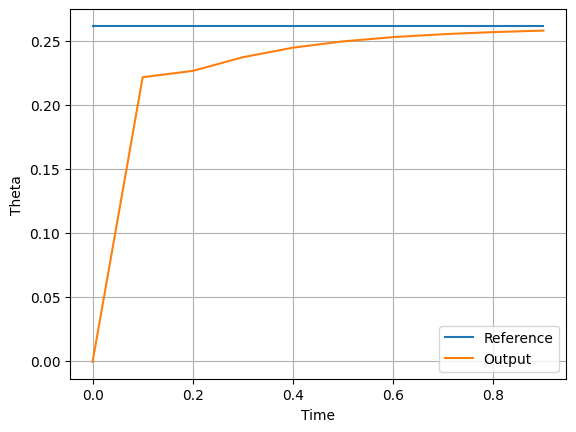

In [106]:
t = test_pd_control["t"]
ref = test_pd_control["theta_ref"]
actual = test_pd_control["theta_rad"]
plt.figure()
plt.plot(t, ref, label = "Reference")
plt.plot(t, actual, label = "Output")
plt.grid(True)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Theta")
plt.show()

We add the integral term into the controller 

In [125]:
def pid_controller(p_vec, ref_traj, time, dt, gain, kp, kd, ki):
    t_hist, u_hist, err_hist, delt_u_hist, theta_hist, ref_hist = [], [], [], [], [], []
    psi_up = 0
    d_filt = 0
    e_int = 0
    prev_theta = None
    alpha = dt/(0.2+dt)
    N = int(time/dt)
    for k in range(N):
        t = k*dt
        if k%(N//10) == 0:
            print(f"Progress: {100*k//N}% done")
        if callable(ref_traj):
            theta_ref,_ = ref_traj(t)
        else:
            theta_ref,_ = ref_traj
        theta_real,_,_,_ = simulate_beam(
                p_vec, psi_up,
                L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
                MU0=MU0, MAGNET_M=MAGNET_M,
                m_line_of_s=m_line_of_s,
                s_steps=200
            )
        error_pd = theta_ref - theta_real
        if prev_theta is None:
            d_meas = 0.0
        else:
            d_meas = -(theta_real - prev_theta)/dt
        prev_theta = theta_real

        d_term = (1-alpha)*d_filt + alpha*d_meas
        d_filt = d_term
        e_int += error_pd*dt

        delta_psi = gain*(kp * error_pd + ki*e_int + kd * d_term)
        psi_up += delta_psi

        t_hist.append(t)
        u_hist.append(psi_up)
        err_hist.append(error_pd)
        delt_u_hist.append(delta_psi)
        theta_hist.append(theta_real)
        ref_hist.append(theta_ref)
    return dict(
        t = np.array(t_hist),
        theta_rad = np.array(theta_hist),
        theta_ref = np.array(ref_hist),
        psi_rad = np.array(u_hist),
        error_rad = np.array(err_hist),
        u_up = np.array(delt_u_hist),
    )


In [126]:
p_vec = np.array([0,0.19,0])
ki=0.05
test_pid_control = pid_controller(p_vec, ref_trajectory, time, dt, gain, kp, kd, ki)

Progress: 0% done
Progress: 10% done
Progress: 20% done
Progress: 30% done
Progress: 40% done
Progress: 50% done
Progress: 60% done
Progress: 70% done
Progress: 80% done
Progress: 90% done


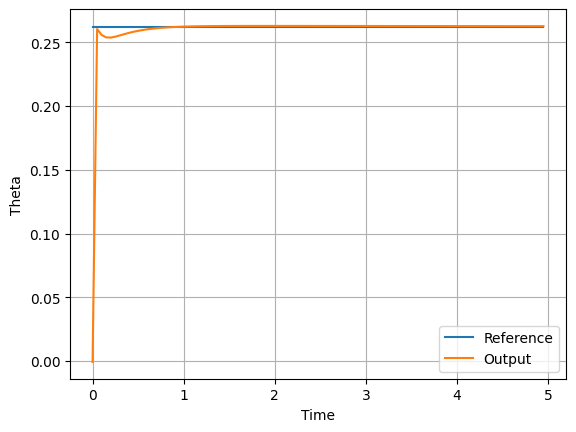

In [127]:
t = test_pid_control["t"]
ref = test_pid_control["theta_ref"]
actual = test_pid_control["theta_rad"]
plt.figure()
plt.plot(t, ref, label = "Reference")
plt.plot(t, actual, label = "Output")
plt.grid(True)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Theta")
plt.show()

In [128]:
Amp = np.deg2rad(15)
freq = 0.25
offset = 00.0
phase = 0.0
time = 5
dt = 0.05
ref_traj_dy = sine_reference(Amp, freq, offset, phase)
dy_pd_con = pd_controller(p_vec, ref_traj_dy, time, dt, gain, kp, kd)

Progress: 0% done


KeyboardInterrupt: 

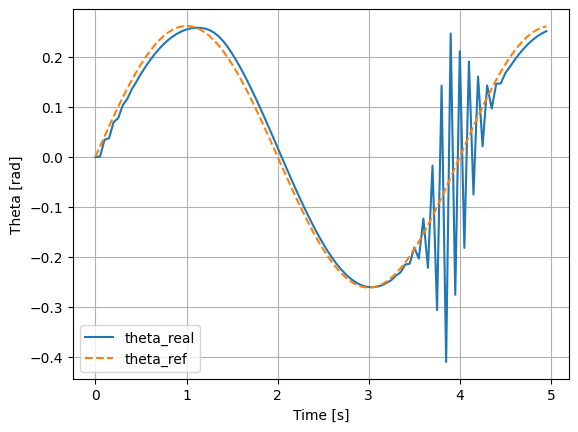

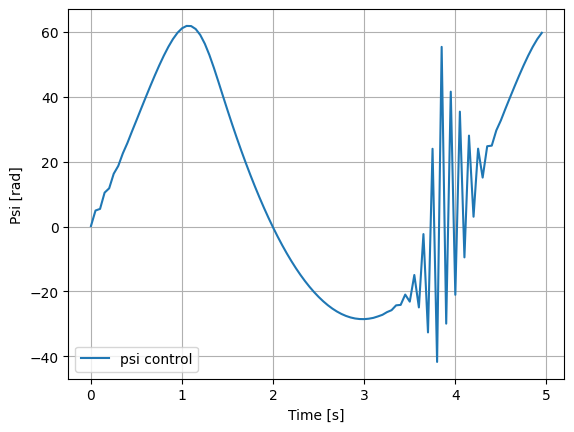

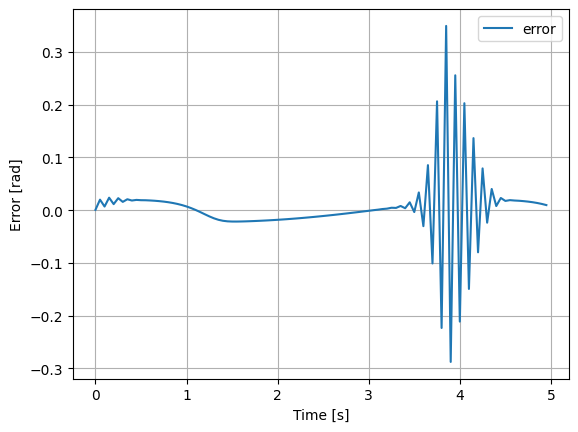

In [123]:
t        = dy_pd_con["t"]
theta    = dy_pd_con["theta_rad"]
theta_ref= dy_pd_con["theta_ref"]
psi      = dy_pd_con["psi_rad"]
error    = dy_pd_con["error_rad"]

plt.figure()
plt.plot(t, theta, label="theta_real")
plt.plot(t, theta_ref, "--", label="theta_ref")
plt.xlabel("Time [s]")
plt.ylabel("Theta [rad]")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, np.rad2deg(psi), label="psi control")
plt.xlabel("Time [s]")
plt.ylabel("Psi [rad]")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, error, label="error")
plt.xlabel("Time [s]")
plt.ylabel("Error [rad]")
plt.legend()
plt.grid(True)

plt.show()

In [129]:
Amp = np.deg2rad(15)
freq = 0.25
offset = 00.0
phase = 0.0
time = 5
dt = 0.05
ref_traj_dy = sine_reference(Amp, freq, offset, phase)
dy_pid_con = pid_controller(p_vec, ref_traj_dy, time, dt, gain, kp, kd, ki)

Progress: 0% done
Progress: 10% done
Progress: 20% done
Progress: 30% done
Progress: 40% done
Progress: 50% done
Progress: 60% done
Progress: 70% done
Progress: 80% done
Progress: 90% done


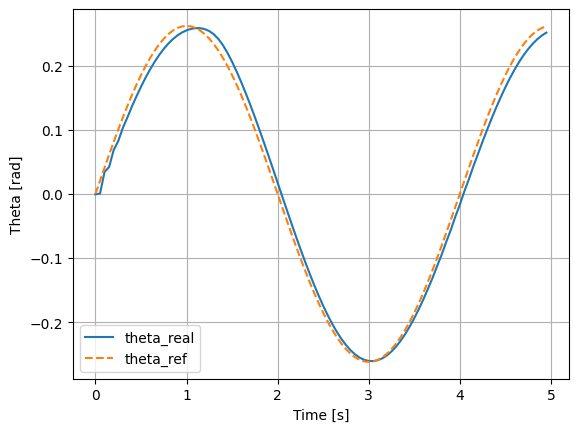

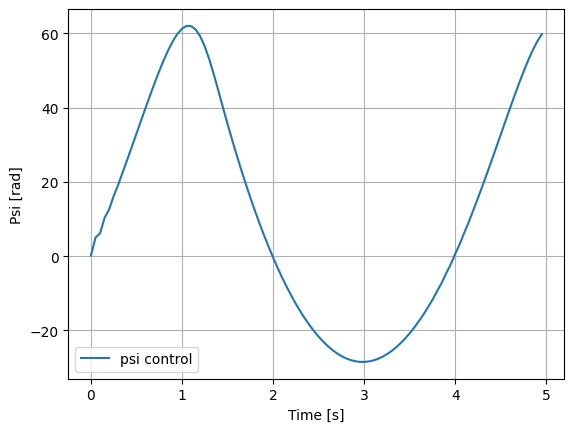

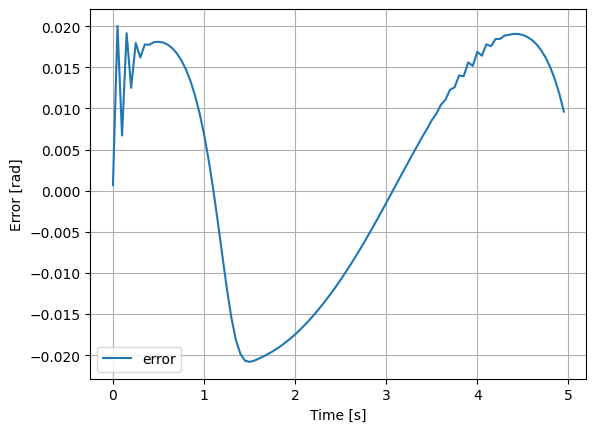

In [131]:
t        = dy_pid_con["t"]
theta    = dy_pid_con["theta_rad"]
theta_ref= dy_pid_con["theta_ref"]
psi      = dy_pid_con["psi_rad"]
error    = dy_pid_con["error_rad"]

plt.figure()
plt.plot(t, theta, label="theta_real")
plt.plot(t, theta_ref, "--", label="theta_ref")
plt.xlabel("Time [s]")
plt.ylabel("Theta [rad]")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, np.rad2deg(psi), label="psi control")
plt.xlabel("Time [s]")
plt.ylabel("Psi [rad]")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, error, label="error")
plt.xlabel("Time [s]")
plt.ylabel("Error [rad]")
plt.legend()
plt.grid(True)

plt.show()

In [133]:
Amp = np.deg2rad(15)
freq = 0.25
offset = 00.0
phase = 0.0
time = 5
dt = 0.05
ref_traj_dy = sine_reference(Amp, freq, offset, phase)
dy_pd_con = pd_controller(p_vec, ref_traj_dy, time, dt, gain, kp, kd)

Progress: 0% done
Progress: 10% done
Progress: 20% done
Progress: 30% done
Progress: 40% done
Progress: 50% done
Progress: 60% done
Progress: 70% done
Progress: 80% done
Progress: 90% done


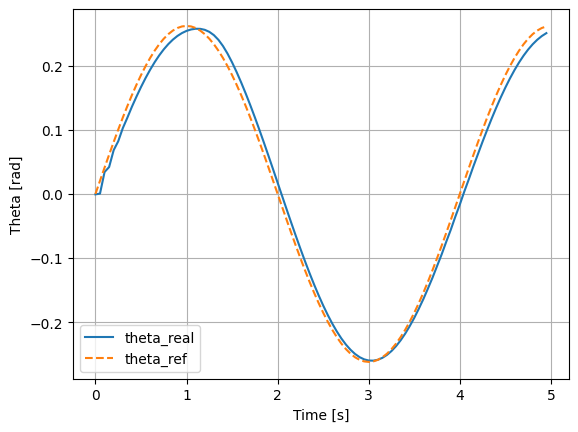

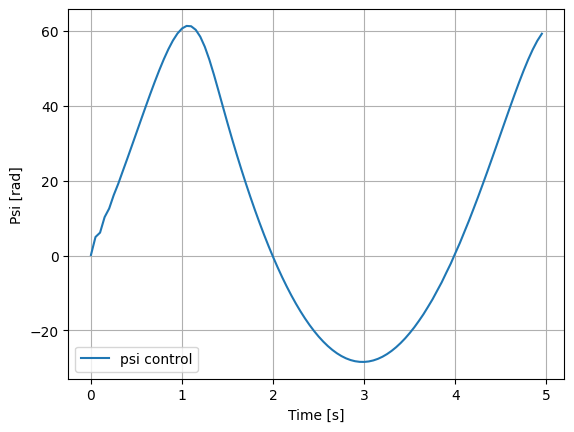

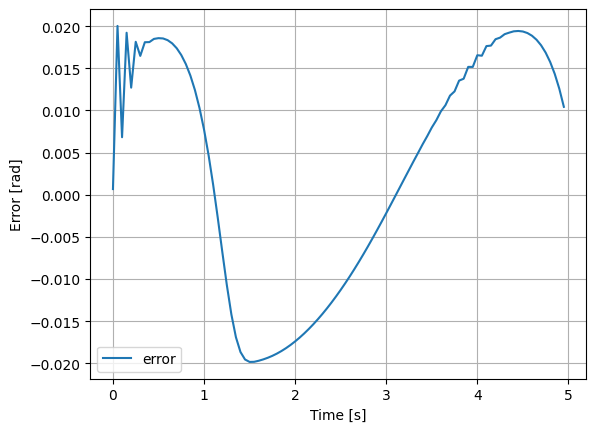

In [135]:
t        = dy_pd_con["t"]
theta    = dy_pd_con["theta_rad"]
theta_ref= dy_pd_con["theta_ref"]
psi      = dy_pd_con["psi_rad"]
error    = dy_pd_con["error_rad"]

plt.figure()
plt.plot(t, theta, label="theta_real")
plt.plot(t, theta_ref, "--", label="theta_ref")
plt.xlabel("Time [s]")
plt.ylabel("Theta [rad]")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, np.rad2deg(psi), label="psi control")
plt.xlabel("Time [s]")
plt.ylabel("Psi [rad]")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, error, label="error")
plt.xlabel("Time [s]")
plt.ylabel("Error [rad]")
plt.legend()
plt.grid(True)

plt.show()